Deep Learning with Flux: A 60 Minute Blitz
=====================

This is a quick intro to [Flux](https://github.com/FluxML/Flux.jl) loosely
based on [PyTorch's
tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).
It introduces basic Julia programming, as well Zygote, a source-to-source
automatic differentiation (AD) framework in Julia.
We'll use these tools to build a very simple neural network.

In [1]:
]st

Status `~/odsceurpoe/ODSCEurope2020/Project.toml`
  [336ed68f] CSV v0.7.7
  [31c24e10] Distributions v0.23.11
  [587475ba] Flux v0.11.1
  [86fae568] ImageView v0.10.9
  [916415d5] Images v0.22.4
  [23992714] MAT v0.8.1
  [dbeba491] Metalhead v0.5.1
  [91a5bcdd] Plots v1.0.14
  [2913bbd2] StatsBase v0.33.1
  [009559a3] XGBoost v1.1.1
  [e88e6eb3] Zygote v0.5.7
  [10745b16] Statistics


Arrays
-------

The starting point for all of our models is the `Array` (sometimes referred to
as a `Tensor` in other frameworks). This is really just a list of numbers,
which might be arranged into a shape like a square. Let's write down an array
with three elements.

In [2]:
x = [1, 2, 3]

3-element Array{Int64,1}:
 1
 2
 3

Here's a matrix – a square array with four elements.

In [3]:
x = [1 2; 3 4]

2×2 Array{Int64,2}:
 1  2
 3  4

We often work with arrays of thousands of elements, and don't usually write
them down by hand. Here's how we can create an array of 5×3 = 15 elements,
each a random number from zero to one.

In [4]:
x = rand(5, 3)

5×3 Array{Float64,2}:
 0.824596   0.861117   0.488273
 0.348176   0.44778    0.304523
 0.825017   0.368134   0.441199
 0.460255   0.466246   0.570456
 0.0171909  0.0675758  0.976182

There's a few functions like this; try replacing `rand` with `ones`, `zeros`,
or `randn` to see what they do.

By default, Julia works stores numbers is a high-precision format called
`Float64`. In ML we often don't need all those digits, and can ask Julia to
work with `Float32` instead. We can even ask for more digits using `BigFloat`.

In [5]:
x = rand(BigFloat, 5, 3)

5×3 Array{BigFloat,2}:
 0.578351  0.618241  0.6919
 0.542198  0.675731  0.208174
 0.181624  0.859533  0.920606
 0.611207  0.997925  0.942422
 0.95015   0.800185  0.323592

In [6]:
x = rand(Float32, 5, 3)

5×3 Array{Float32,2}:
 0.873278  0.856443  0.286719
 0.561015  0.233928  0.657078
 0.966198  0.66904   0.825555
 0.274162  0.444862  0.425979
 0.885508  0.704317  0.81826

We can ask the array how many elements it has.

In [7]:
length(x)

15

Or, more specifically, what size it has.

In [8]:
size(x)

(5, 3)

We sometimes want to see some elements of the array on their own.

In [9]:
x

5×3 Array{Float32,2}:
 0.873278  0.856443  0.286719
 0.561015  0.233928  0.657078
 0.966198  0.66904   0.825555
 0.274162  0.444862  0.425979
 0.885508  0.704317  0.81826

In [10]:
x[6]

0.8564434f0

In [11]:
x[2, 3]

0.6570779f0

This means get the second row and the third column. We can also get every row
of the third column.

In [12]:
x[:, 3]

5-element Array{Float32,1}:
 0.2867186
 0.6570779
 0.8255546
 0.42597866
 0.8182603

We can add arrays, and subtract them, which adds or subtracts each element of
the array.

In [13]:
x + x

5×3 Array{Float32,2}:
 1.74656   1.71289   0.573437
 1.12203   0.467856  1.31416
 1.9324    1.33808   1.65111
 0.548324  0.889724  0.851957
 1.77102   1.40863   1.63652

In [14]:
x - x

5×3 Array{Float32,2}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

Julia supports a feature called *broadcasting*, using the `.` syntax. This
tiles small arrays (or single numbers) to fill bigger ones.

In [15]:
x .+ 1

5×3 Array{Float32,2}:
 1.87328  1.85644  1.28672
 1.56102  1.23393  1.65708
 1.9662   1.66904  1.82555
 1.27416  1.44486  1.42598
 1.88551  1.70432  1.81826

We can see Julia tile the column vector `1:5` across all rows of the larger
array.

In [16]:
zeros(5,5) .+ (1:5)

5×5 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0
 2.0  2.0  2.0  2.0  2.0
 3.0  3.0  3.0  3.0  3.0
 4.0  4.0  4.0  4.0  4.0
 5.0  5.0  5.0  5.0  5.0

The x' syntax is used to transpose a column `1:5` into an equivalent row, and
Julia will tile that across columns.

In [17]:
zeros(5,5) .+ (1:5)'

5×5 Array{Float64,2}:
 1.0  2.0  3.0  4.0  5.0
 1.0  2.0  3.0  4.0  5.0
 1.0  2.0  3.0  4.0  5.0
 1.0  2.0  3.0  4.0  5.0
 1.0  2.0  3.0  4.0  5.0

We can use this to make a times table.

In [18]:
(1:5) .* (1:5)'

5×5 Array{Int64,2}:
 1   2   3   4   5
 2   4   6   8  10
 3   6   9  12  15
 4   8  12  16  20
 5  10  15  20  25

Finally, and importantly for machine learning, we can conveniently do things like
matrix multiply.

In [19]:
W = randn(5, 10)
x = rand(10)
W * x

5-element Array{Float64,1}:
 -0.5496259984930997
  0.5306537477587597
 -0.7834282309393603
 -1.2524829970371323
  1.9339945289972387

Julia's arrays are very powerful, and you can learn more about what they can
do [here](https://docs.julialang.org/en/v1/manual/arrays/).

### CUDA Arrays

CUDA functionality is provided separately by the [CUDA.jl
package](https://github.com/JuliaGPU/CUDA.jl). If you have a GPU and CUDA
available, you can run `] add CUDA` in a REPL or IJulia to get it.

Once CUDA is loaded you can move any array to the GPU with the `cu`
function, and it supports all of the above operations with the same syntax.

In [20]:
using Flux

In [21]:
using Flux: gpu
x = gpu(rand(5, 3))

5×3 CUDA.CuArray{Float32,2}:
 0.67829    0.19216    0.0141088
 0.0942092  0.0980978  0.914918
 0.86526    0.923609   0.520958
 0.936102   0.579317   0.857491
 0.850112   0.293006   0.316404

Automatic Differentiation
-------------------------

You probably learned to take derivatives in school. We start with a simple
mathematical function like

In [22]:
f(x) = 3x^2 + 2x + 1

f(5)

86

In simple cases it's pretty easy to work out the gradient by hand – here it's
`6x+2`. But it's much easier to make Flux do the work for us!

In [23]:
using Flux: gradient

df(x) = gradient(f, x)[1]

df(5)

32

You can try this with a few different inputs to make sure it's really the same
as `6x+2`. We can even do this multiple times (but the second derivative is a
fairly boring `6`).

In [216]:
ddf(x) = gradient(df, x)[1]

ddf(5)

6

Flux's AD can handle any Julia code you throw at it, including loops,
recursion and custom layers, so long as the mathematical functions you call
are differentiable. For example, we can differentiate a Taylor approximation
to the `sin` function.

In [218]:
mysin(x) = sum(((-1)^k * x ^ (1 + 2k)) / factorial(1 + 2k) for k in 0:5)

x = 0.5

mysin(x), gradient(mysin, x)

(0.4794255386041834, (0.8775825618898637,))

In [26]:
sin(x), cos(x)

(0.479425538604203, 0.8775825618903728)

You can see that the derivative we calculated is very close to `cos(x)`, as we
expect.

This gets more interesting when we consider functions that take *arrays* as
inputs, rather than just a single number. For example, here's a function that
takes a matrix and two vectors (the definition itself is arbitrary)

$$ y = σ.(W * x + b) $$

In [27]:
myloss(W, b, x) = sum(W * x .+ b)

W = randn(3, 5)
b = zeros(3)
x = rand(5)

gradient(myloss, W, b, x)

([0.1664157407065745 0.5096435744602996 … 0.9193291812019386 0.5111594838846711; 0.1664157407065745 0.5096435744602996 … 0.9193291812019386 0.5111594838846711; 0.1664157407065745 0.5096435744602996 … 0.9193291812019386 0.5111594838846711], 3-element Fill{Float64}: entries equal to 1.0, [1.0458884189362463, 1.0020339963964158, 0.14386219795708757, -1.2417759039713478, -2.4611376877236593])

Now we get gradients for each of the inputs `W`, `b` and `x`, which will come
in handy when we want to train models.

Because ML models can contain hundreds of parameters, Flux provides a slightly
different way of writing `gradient`. We instead mark arrays with `param` to
indicate that we want their derivatives. `W` and `b` represent the weight and
bias respectively.

In [28]:
using Flux: params

W = randn(3, 5)
b = zeros(3)
x = rand(5)

y(x) = sum(W * x .+ b)

grads = gradient(()->y(x), params(W, b))

grads[W], grads[b]

([0.1029736362657463 0.1350489307017686 … 0.9999214786307322 0.5684525512301466; 0.1029736362657463 0.1350489307017686 … 0.9999214786307322 0.5684525512301466; 0.1029736362657463 0.1350489307017686 … 0.9999214786307322 0.5684525512301466], 3-element Fill{Float64}: entries equal to 1.0)

We can now grab the gradients of `W` and `b` directly from those parameters.

This comes in handy when working with *layers*. A layer is just a handy
container for some parameters. For example, `Dense` does a linear transform
for you.

In [29]:
using Flux

m = Dense(10, 5)

x = rand(Float32, 10)

10-element Array{Float32,1}:
 0.46337426
 0.6444974
 0.34239125
 0.08695817
 0.82229733
 0.40837836
 0.62483084
 0.59043694
 0.0017986298
 0.74462855

We can easily get the parameters of any layer or model with params with
`params`.

In [30]:
params(m)

Params([Float32[-0.4810946 0.095490545 … 0.06745251 0.57409954; -0.14792295 0.5733329 … -0.04754985 -0.085658036; … ; 0.44672158 -0.20107432 … -0.44465715 0.57285357; 0.5459392 0.13856709 … 0.24982534 -0.60930127], Float32[0.0, 0.0, 0.0, 0.0, 0.0]])

This makes it very easy to calculate the gradient for all
parameters in a network, even if it has many parameters.

In [31]:
x = rand(Float32, 10)
m = Chain(Dense(10, 5, relu),
          identity,
          Dense(5, 2),
          softmax)
l(x) = sum(Flux.crossentropy(m(x), [0.5, 0.5]))
grads = gradient(params(m)) do
    l(x)
end
for p in params(m)
    println(grads[p])
end

AbstractFloat[0.05211236138041907 0.05704720935427655 0.17874304669249622 0.14671702663823047 0.022820314362028252 0.16840890321917815 0.03803498544378751 0.0838686278922419 0.1111246333572342 0.027252212880928776; 0.06015193897654093 0.06584810522805756 0.20631843486501356 0.16935163556949145 0.026340893418926578 0.19439000270197945 0.04390279125305549 0.09680736879668501 0.12826826471552774 0.03145651823801787; 0.0f0 0.0f0 0.0f0 0.0f0 0.0f0 0.0f0 0.0f0 0.0f0 0.0f0 0.0f0; 0.039522248520745464 0.04326485934989465 0.13555952801997623 0.11127085081966298 0.017307028728821054 0.12772206727587374 0.02884590349339141 0.06360634342500895 0.08427742017408488 0.02066820043631779; -0.0387496651336252 -0.042419115172098745 -0.1329096018838374 -0.10909572126525809 -0.016968709848272503 -0.12522534831277626 -0.028282021966919795 -0.06236296264367933 -0.08262995989100724 -0.020264177160911553]
AbstractFloat[0.20135760136722952, 0.23242182524577137, 0.0f0, 0.1527105076794132, -0.14972531311969864]
[

You don't have to use layers, but they can be convient for many simple kinds
of models and fast iteration.

The next step is to update our weights and perform optimisation. As you might be
familiar, *Gradient Descent* is a simple algorithm that takes the weights and steps
using a learning rate and the gradients. `weights = weights - learning_rate * gradient`.

In [32]:
using Flux.Optimise: update!, Descent
η = 0.1
for p in params(m)
  update!(p, -η * grads[p])
end

While this is a valid way of updating our weights, it can get more complicated as the
algorithms we use get more involved.

Flux comes with a bunch of pre-defined optimisers and makes writing our own really simple.
We just give it the learning rate η

In [33]:
opt = Descent(0.01)
update!(opt, params(m), grads)

`Training` a network reduces down to iterating on a dataset mulitple times, performing these
steps in order. Just for a quick implementation, let’s train a network that learns to predict
`0.5` for every input of 10 floats. `Flux` defines the `train!` function to do it for us.

In [34]:
data, labels = rand(10, 100), fill(0.5, 2, 100)
loss(x, y) = sum(Flux.crossentropy(m(x), y))
Flux.train!(loss, params(m), [(data,labels), (data,labels)], opt)

You don't have to use `train!`. In cases where aribtrary logic might be better suited,
you could open up this training loop like so:

```julia
  for d in training_set # assuming d looks like (data, labels)
    # our super logic
    gs = gradient(params(m)) do #m is our model
      l = loss(d...)
    end
    update!(opt, params(m), gs)
  end
```

Training a Classifier
---------------------

Getting a real classifier to work might help cement the workflow a bit more.
[CIFAR10](url) is a dataset of 50k tiny training images split into 10 classes.

We will do the following steps in order:

* Load CIFAR10 training and test datasets
* Define a Convolution Neural Network
* Define a loss function
* Train the network on the training data
* Test the network on the test data

Loading the Dataset

[Metalhead.jl](https://github.com/FluxML/Metalhead.jl) is an excellent package
that has a number of predefined and pretrained computer vision models.
It also has a number of dataloaders that come in handy to load datasets.

In [35]:
using Statistics
using Zygote
using Flux, Flux.Optimise
using Metalhead, Images
using Metalhead: trainimgs
using Images.ImageCore
using Flux: onehotbatch, onecold
using Base.Iterators: partition

The image will give us an idea of what we are dealing with.
![title](https://pytorch.org/tutorials/_images/cifar10.png)

In [193]:
image(x) = x.img # handy for use later
ground_truth(x) = x.ground_truth
class(x) = x.class

class (generic function with 1 method)

In [194]:
Metalhead.download(CIFAR10)
X = trainimgs(CIFAR10)
labels = onehotbatch(class.(ground_truth.(X)), 1:10) # onehotbatch(actual_classes, available_classes)

10×50000 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  1  0  1  0  0  0  0  0
 0  0  0  0  1  1  0  0  0  0  0  0  0     0  1  0  0  0  1  0  0  0  0  1  1
 0  0  0  0  0  0  1  0  0  0  0  0  0     0  0  0  1  0  0  0  1  0  0  0  0
 0  0  0  0  0  0  0  0  0  1  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0  1  0  0     0  0  1  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  1  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  1  0  0  0
 0  0  0  0  0  0  0  1  0  0  0  1  1     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  1  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  1  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  1  0  0

Let's take a look at a random image from the dataset

,,,,,,,,,

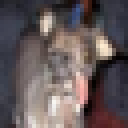
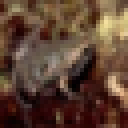
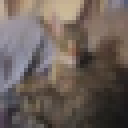
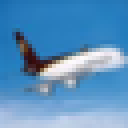
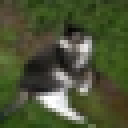
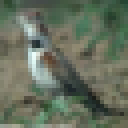
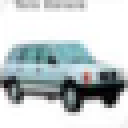
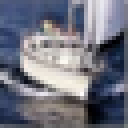
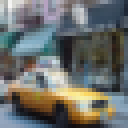
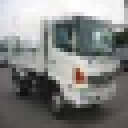

In [195]:
image.(X[rand(1:end, 10)])

The images are simply 32 X 32 matrices of numbers in 3 channels (R,G,B). We can now
arrange them in batches of say, 1000 and keep a validation set to track our progress.
This process is called minibatch learning, which is a popular method of training
large neural networks. Rather that sending the entire dataset at once, we break it
down into smaller chunks (called minibatches) that are typically chosen at random,
and train only on them. It is shown to help with escaping
[saddle points](https://en.wikipedia.org/wiki/Saddle_point).

Defining a `getarray` function would help in converting the matrices to `Float` type.

In [196]:
getarray(X) = float.(permutedims(channelview(X), (2, 3, 1)))
imgs = getarray.(image.(X))

50000-element Array{Array{Float32,3},1}:
 [0.23137255 0.16862746 … 0.59607846 0.5803922; 0.0627451 0.0 … 0.46666667 0.47843137; … ; 0.7058824 0.6784314 … 0.38039216 0.3254902; 0.69411767 0.65882355 … 0.5921569 0.48235294]

[0.24313726 0.18039216 … 0.49019608 0.4862745; 0.078431375 0.0 … 0.3254902 0.34117648; … ; 0.54509807 0.48235294 … 0.24313726 0.20784314; 0.5647059 0.5058824 … 0.4627451 0.36078432]

[0.24705882 0.1764706 … 0.4 0.40392157; 0.078431375 0.0 … 0.19607843 0.22352941; … ; 0.3764706 0.16470589 … 0.13333334 0.13333334; 0.45490196 0.36862746 … 0.32941177 0.28235295]
 [0.6039216 0.49411765 … 0.34117648 0.30980393; 0.54901963 0.5686275 … 0.3019608 0.2784314; … ; 0.64705884 0.6117647 … 0.48235294 0.5137255; 0.6392157 0.61960787 … 0.56078434 0.56078434]

[0.69411767 0.5372549 … 0.3529412 0.31764707; 0.627451 0.6 … 0.3137255 0.28627452; … ; 0.6039216 0.59607846 … 0.44705883 0.4745098; 0.5803922 0.5803922 … 0.5254902 0.52156866]

[0.73333335 0.53333336 … 0.2784314 0.27450982; 0.66

The first 49k images (in batches of 1000) will be our training set, and the rest is
for validation. `partition` handily breaks down the set we give it in consecutive parts
(1000 in this case). `cat` is a shorthand for concatenating multi-dimensional arrays along
any dimension.

In [197]:
# W H C N
# (data, labels) -> minibatch
# [mb1, mb2, ...] -> dataset
train = ([(cat(imgs[i]..., dims = 4), labels[:,i]) for i in partition(1:49000, 1000)]) |> gpu
valset = 49001:50000
valX = cat(imgs[valset]..., dims = 4) |> gpu
valY = labels[:, valset] |> gpu

10×1000 Flux.OneHotMatrix{CUDA.CuArray{Flux.OneHotVector,1}}:
 0  0  0  0  1  0  1  0  0  0  0  0  0  …  0  0  0  0  1  0  1  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  1  0  0  0  1  0  0  0  0  1  1
 0  0  0  0  0  0  0  0  1  0  0  0  0     0  0  0  1  0  0  0  1  0  0  0  0
 0  0  0  0  0  0  0  0  0  1  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0  0  0  0  0  0     0  0  1  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  0  …  1  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  1  0  0  0
 0  0  0  0  0  0  0  0  0  0  1  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  1  0  0  0  1  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  1  0  0  0  0  0  0  0  0  1     0  0  0  0  0  0  0  0  0  1  0  0

## Defining the Classifier
--------------------------
Now we can define our Convolutional Neural Network (CNN).

A convolutional neural network is one which defines a kernel and slides it across a matrix
to create an intermediate representation to extract features from. It creates higher order
features as it goes into deeper layers, making it suitable for images, where the strucure of
the subject is what will help us determine which class it belongs to.

In [199]:
# Flux.Data.Dataloader
# MLDataUtils.jl, MLDatasets.jl
train[1][1]

32×32×3×1000 CUDA.CuArray{Float32,4}:
[:, :, 1, 1] =
 0.231373   0.168627   0.196078   0.266667  …  0.619608  0.596078  0.580392
 0.0627451  0.0        0.0705882  0.2          0.482353  0.466667  0.478431
 0.0980392  0.0627451  0.192157   0.32549      0.462745  0.470588  0.427451
 0.129412   0.14902    0.341176   0.415686     0.490196  0.47451   0.368627
 0.196078   0.231373   0.4        0.498039     0.341176  0.294118  0.262745
 0.278431   0.329412   0.431373   0.505882  …  0.262745  0.137255  0.12549
 0.380392   0.435294   0.482353   0.509804     0.376471  0.34902   0.258824
 0.45098    0.466667   0.509804   0.54902      0.396078  0.494118  0.4
 0.537255   0.501961   0.517647   0.501961     0.466667  0.490196  0.52549
 0.603922   0.603922   0.611765   0.54902      0.517647  0.501961  0.521569
 0.603922   0.607843   0.611765   0.576471  …  0.533333  0.509804  0.52549
 0.568627   0.572549   0.572549   0.529412     0.521569  0.517647  0.521569
 0.556863   0.552941   0.54902    0.564706 

In [200]:
m = Chain(
  Conv((5,5), 3=>16, relu),
  MaxPool((2,2)),
  Conv((5,5), 16=>8, relu),
  MaxPool((2,2)),
  x -> reshape(x, :, size(x, 4)),
  Dense(200, 120),
  Dense(120, 84),
  Dense(84, 10),
  softmax) |> gpu

Chain(Conv((5, 5), 3=>16, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((5, 5), 16=>8, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), #73, Dense(200, 120), Dense(120, 84), Dense(84, 10), softmax)

We will use a crossentropy loss and an Momentum optimiser here. Crossentropy will be a
good option when it comes to working with mulitple independent classes. Momentum gradually
lowers the learning rate as we proceed with the training. It helps maintain a bit of
adaptivity in our optimisation, preventing us from over shooting from our desired destination.

$$ y\hat = model(x) $$

In [202]:
using Flux: crossentropy, Momentum

loss(x, y) = sum(crossentropy(m(x), y))
opt = Momentum(0.01)

Momentum(0.01, 0.9, IdDict{Any,Any}())

We can start writing our train loop where we will keep track of some basic accuracy
numbers about our model. We can define an `accuracy` function for it like so.

In [205]:
accuracy(x, y) = mean(onecold(cpu(m(x)), 1:10) .== onecold(cpu(y), 1:10))

accuracy (generic function with 1 method)

## Training
-----------

Training is where we do a bunch of the interesting operations we defined earlier,
and see what our net is capable of. We will loop over the dataset 10 times and
feed the inputs to the neural network and optimise.

In [208]:
# Flux.train!(loss, ps, data, opt, cb = (...))


epochs = 10

for epoch = 1:epochs
  for d in train
    gs = gradient(params(m)) do
      l = loss(d...)
    end
    update!(opt, params(m), gs)
  end
  @show accuracy(valX, valY)
end

accuracy(valX, valY) = 0.523
accuracy(valX, valY) = 0.521
accuracy(valX, valY) = 0.526
accuracy(valX, valY) = 0.539
accuracy(valX, valY) = 0.539
accuracy(valX, valY) = 0.542
accuracy(valX, valY) = 0.555
accuracy(valX, valY) = 0.565
accuracy(valX, valY) = 0.552
accuracy(valX, valY) = 0.559


Seeing our training routine unfold gives us an idea of how the network learnt the
This is not bad for a small hand-written network, trained for a limited time.

Training on a GPU
-----------------

The `gpu` functions you see sprinkled through this bit of the code tell Flux to move
these entities to an available GPU, and subsequently train on it. No extra faffing
about required! The same bit of code would work on any hardware with some small
annotations like you saw here.

## Testing the Network
----------------------

We have trained the network for 100 passes over the training dataset. But we need to
check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and
checking it against the ground-truth. If the prediction is correct, we add the sample
to the list of correct predictions. This will be done on a yet unseen section of data.

Okay, first step. Let us perform the exact same preprocessing on this set, as we did
on our training set.

In [209]:
valset = Metalhead.valimgs(CIFAR10)
valimg = [getarray(valset[i].img) for i in 1:10000]
labels = onehotbatch([valset[i].ground_truth.class for i in 1:10000],1:10)
test = gpu.([(cat(valimg[i]..., dims = 4), labels[:,i]) for i in partition(1:10000, 1000)])

10-element Array{Tuple{CUDA.CuArray{Float32,4},Flux.OneHotMatrix{CUDA.CuArray{Flux.OneHotVector,1}}},1}:
 ([0.61960787 0.62352943 … 0.49411765 0.45490196; 0.59607846 0.5921569 … 0.49019608 0.46666667; … ; 0.23921569 0.19215687 … 0.11372549 0.078431375; 0.21176471 0.21960784 … 0.13333334 0.08235294]

[0.4392157 0.43529412 … 0.35686275 0.33333334; 0.4392157 0.43137255 … 0.35686275 0.34509805; … ; 0.45490196 0.4 … 0.32156864 0.2509804; 0.41960785 0.4117647 … 0.32941177 0.2627451]

[0.19215687 0.18431373 … 0.14117648 0.12941177; 0.2 0.15686275 … 0.1254902 0.13333334; … ; 0.65882355 0.5803922 … 0.49411765 0.41960785; 0.627451 0.58431375 … 0.5058824 0.43137255]

[0.92156863 0.90588236 … 0.9137255 0.9098039; 0.93333334 0.92156863 … 0.9254902 0.92156863; … ; 0.32156864 0.18039216 … 0.7254902 0.73333335; 0.33333334 0.24313726 … 0.7058824 0.7294118]

[0.92156863 0.90588236 … 0.9137255 0.9098039; 0.93333334 0.92156863 … 0.9254902 0.92156863; … ; 0.3764706 0.22352941 … 0.78431374 0.7921569; 0.3960

Next, display some of the images from the test set.

,,,,,,,,,

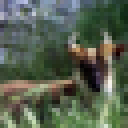
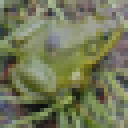
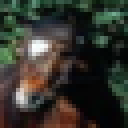
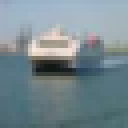
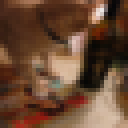
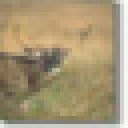
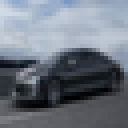
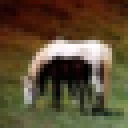
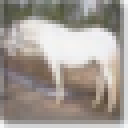
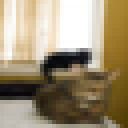

In [210]:
ids = rand(1:10000, 10)
image.(valset[ids])

The outputs are energies for the 10 classes. Higher the energy for a class, the more the
network thinks that the image is of the particular class. Every column corresponds to the
output of one image, with the 10 floats in the column being the energies.

Let's see how the model fared.

In [211]:
ids = rand(1:10000, 1000)
rand_test = getarray.(image.(valset[ids]))
rand_test = cat(rand_test..., dims = 4) |> gpu
rand_truth = ground_truth.(valset[ids])
rand_truth = class.(rand_truth)
op_test = m(rand_test)

10×1000 CUDA.CuArray{Float32,2}:
 0.361702    0.752502     0.00145399  …  0.00288521  0.0397814   0.049462
 0.0122657   0.0301652    0.037621       0.00220341  0.00634744  0.00134109
 0.346332    0.00658156   0.0378321      0.0111104   0.174368    0.000111776
 0.0140035   0.0629492    0.0588202      0.71503     0.126512    1.65209f-6
 0.0283672   0.00617254   0.044954       0.00154363  0.188099    6.17493f-6
 0.0104762   0.00717852   0.615102    …  0.258693    0.137272    4.48546f-7
 0.147106    0.00547686   0.1788         0.00100871  0.226154    4.57029f-8
 0.00198456  0.000834688  0.0155913      0.00416268  0.0696157   2.5117f-6
 0.0743906   0.0695673    0.00267944     0.00025254  0.0270106   0.948624
 0.00337211  0.0585725    0.00714609     0.00311036  0.00484035  0.000449973

This looks similar to how we would expect the results to be. At this point, it's a good
idea to see how our net actually performs on new data, that we have prepared.

In [212]:
accuracy(test[1]...)

0.565

This is much better than random chance set at 10% (since we only have 10 classes), and
not bad at all for a small hand written network like ours.

Let's take a look at how the net performed on all the classes performed individually.

In [213]:
op_test = cpu(op_test)
op_classes = onecold(op_test)

class_pred = zeros(10)
class_actual = zeros(10)
for (actual, pred) in zip(rand_truth, op_classes)
    if actual == pred
        class_pred[pred] += 1
    end
    class_actual[actual] += 1
end

class_pred ./ class_actual

10-element Array{Float64,1}:
 0.5267857142857143
 0.7572815533980582
 0.3969465648854962
 0.3238095238095238
 0.40594059405940597
 0.5544554455445545
 0.7037037037037037
 0.5060240963855421
 0.696969696969697
 0.4880952380952381

The spread seems pretty good, with certain classes performing significantly better than the others.
Why should that be?